In [23]:
%matplotlib inline
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------
def initialstate(N):   
    ''' generates a random spin configuration for initial condition'''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state


def mcmove(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config


def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.


def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag

def critical_temp(J, k_B):
    return 2*J/(k_B*np.log(1+np.sqrt(2)))

In [24]:
## change these parameters for a smaller (faster) simulation 
nt      = 100         #  number of temperature points
N       = 28         #  size of the lattice, N x N
eqSteps = 2000       #  number of MC sweeps for equilibration
mcSteps = 2000       #  number of MC sweeps for calculation

T       = np.linspace(1.53, 3.28, nt); 
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
# divide by number of samples, and by system size to get intensive values

In [25]:
#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------
for tt in range(nt):
    E1 = M1 = E2 = M2 = 0
    config = initialstate(N)
    iT=1.0/T[tt]; iT2=iT*iT;
    
    for i in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    for i in range(mcSteps):
        mcmove(config, iT)           
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

    E[tt] = n1*E1
    M[tt] = n1*M1
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT

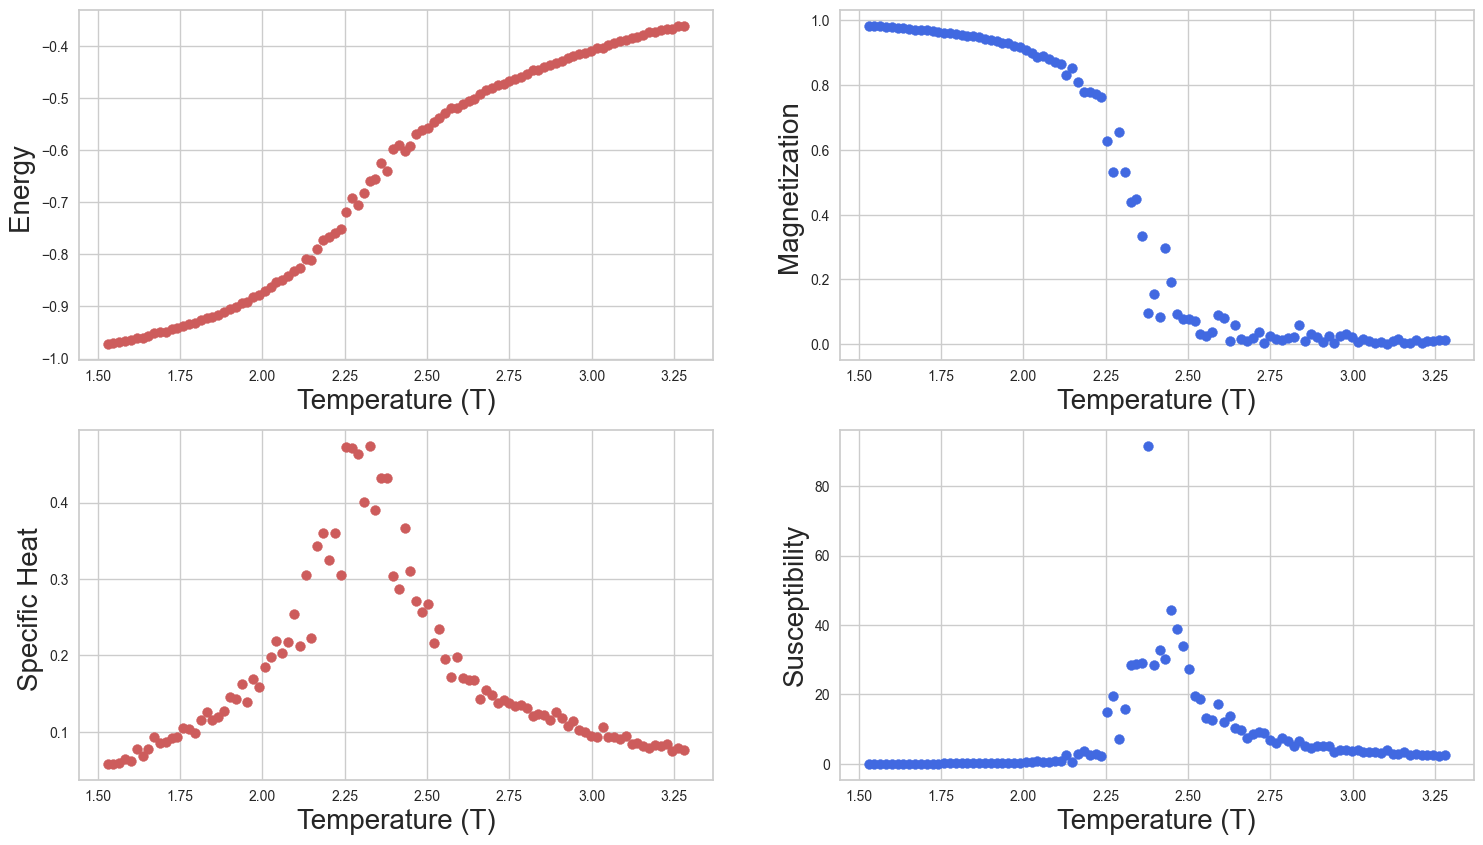

In [26]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');

In [27]:
Tc = critical_temp(1, 1)
print("Critical temperature: ", Tc)

Critical temperature:  2.269185314213022


In [28]:
import pandas as pd
df = pd.DataFrame({'T':T, 'M':abs(M)})

# add a phase classification column
df['phase'] = df['T'].apply(lambda x: int(1) if x > Tc else int(0))

In [29]:
print(df)

           T         M  phase
0   1.530000  0.984032      0
1   1.547677  0.983325      0
2   1.565354  0.982168      0
3   1.583030  0.980790      0
4   1.600707  0.979728      0
..       ...       ...    ...
95  3.209293  0.003366      1
96  3.226970  0.010916      1
97  3.244646  0.009213      1
98  3.262323  0.012482      1
99  3.280000  0.011499      1

[100 rows x 3 columns]


In [30]:
from pycaret.classification import *

In [31]:
experiment = setup(data = df,  target = 'phase', train_size= 0.6, ignore_features=['T'], session_id=123)

,Description,Value
0,Session id,123
1,Target,phase
2,Target type,Binary
3,Original data shape,"(100, 3)"
4,Transformed data shape,"(100, 2)"
5,Transformed train set shape,"(60, 2)"
6,Transformed test set shape,"(40, 2)"
7,Ignore features,1
8,Numeric features,1
9,Preprocess,True


In [32]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [33]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9833,1.0000,0.9750,1.0000,0.9857,0.9667,0.9707,0.8050
knn,K Neighbors Classifier,0.9833,1.0000,0.9750,1.0000,0.9857,0.9667,0.9707,0.4320
nb,Naive Bayes,0.9667,1.0000,0.9750,0.9750,0.9714,0.9333,0.9414,0.2160
dt,Decision Tree Classifier,0.9667,0.9708,0.9750,0.9750,0.9714,0.9333,0.9414,0.2150
svm,SVM - Linear Kernel,0.9667,0.0000,0.9667,0.9750,0.9657,0.9333,0.9414,0.2080
ridge,Ridge Classifier,0.9667,0.0000,0.9417,1.0000,0.9657,0.9333,0.9414,0.2200
rf,Random Forest Classifier,0.9667,1.0000,0.9750,0.9750,0.9714,0.9333,0.9414,0.3330
qda,Quadratic Discriminant Analysis,0.9667,1.0000,0.9750,0.9750,0.9714,0.9333,0.9414,0.2180
ada,Ada Boost Classifier,0.9667,0.9708,0.9750,0.9750,0.9714,0.9333,0.9414,0.2470
gbc,Gradient Boosting Classifier,0.9667,0.9708,0.9750,0.9750,0.9714,0.9333,0.9414,0.2750


In [34]:
lr = create_model('lr')
evaluate_model(lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

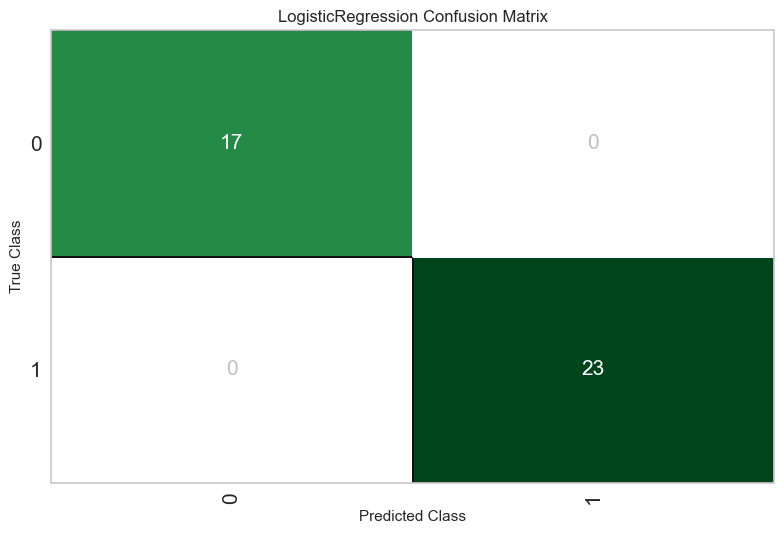

In [35]:
plot_model(lr, plot = 'confusion_matrix')

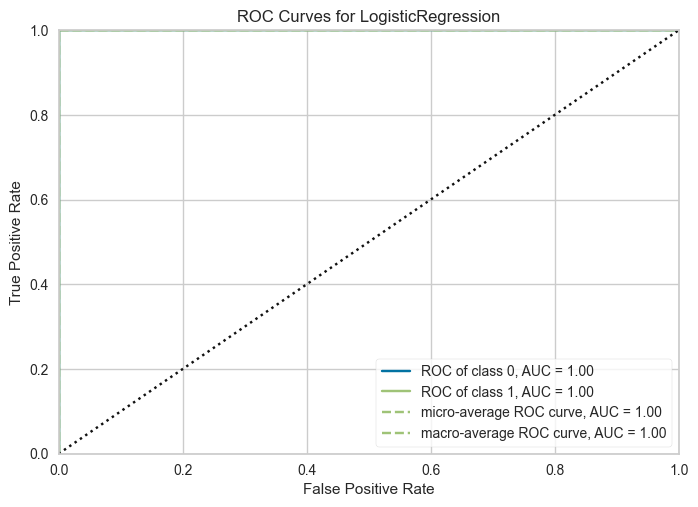

In [36]:
plot_model(lr, plot = 'auc')

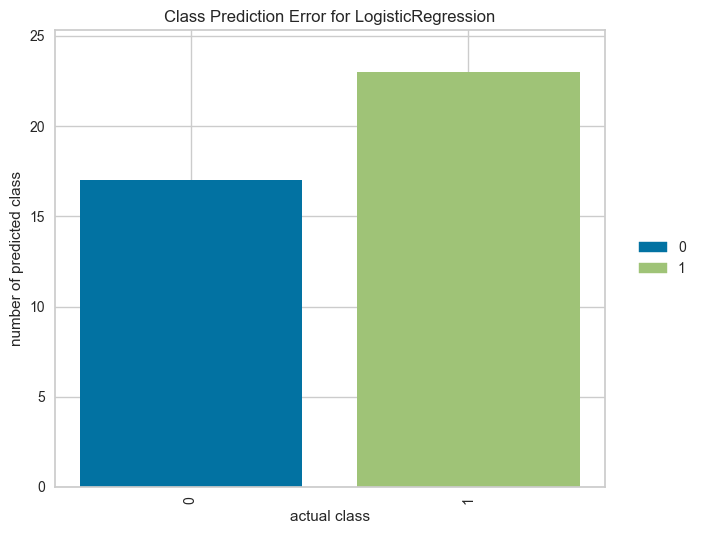

In [37]:
plot_model(lr, plot = 'error')

In [38]:
pred_holdout = predict_model(lr)

In [39]:
pred_holdout

,M,phase,prediction_label,prediction_score
30,0.891017,0,0,0.7762
69,0.025626,1,1,0.8825
64,0.017341,1,1,0.8857
31,0.882024,0,0,0.7702
0,0.984032,0,0,0.8311
58,0.025917,1,1,0.8824
52,0.192177,1,1,0.8004
57,0.031193,1,1,0.8803
82,0.032223,1,1,0.8799
2,0.982168,0,0,0.8302


In [40]:
# copy data and drop Class variable

new_data = df.copy()
new_data.drop('T', axis=1, inplace=True)
new_data.head()

,M,phase
0,0.984032,0
1,0.983325,0
2,0.982168,0
3,0.980790,0
4,0.979728,0


In [41]:
# predict model on new_data
predictions = predict_model(lr,data = new_data)
predictions.head()

,M,phase,prediction_label,prediction_score
0,0.984032,0,0,0.8311
1,0.983325,0,0,0.8308
2,0.982168,0,0,0.8302
3,0.980790,0,0,0.8294
4,0.979728,0,0,0.8289


Text(0, 0.5, 'predicted phase')

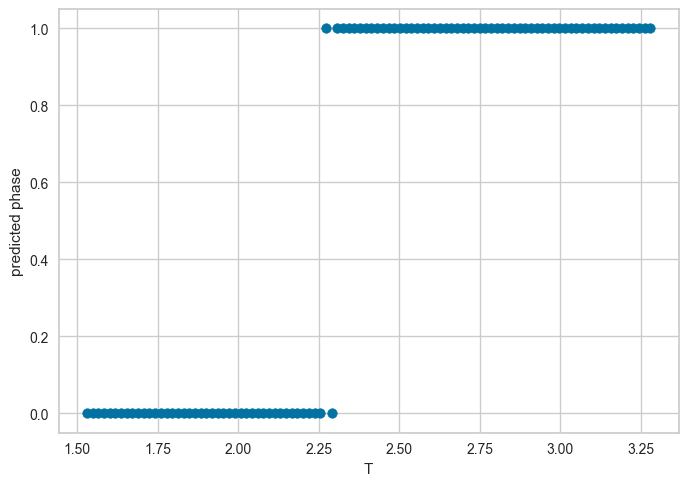

In [48]:
import matplotlib.pyplot as plt
plt.scatter(df['T'], predictions['prediction_label'])
plt.xlabel('T')
plt.ylabel('predicted phase')

Text(0, 0.5, 'predicted phase')

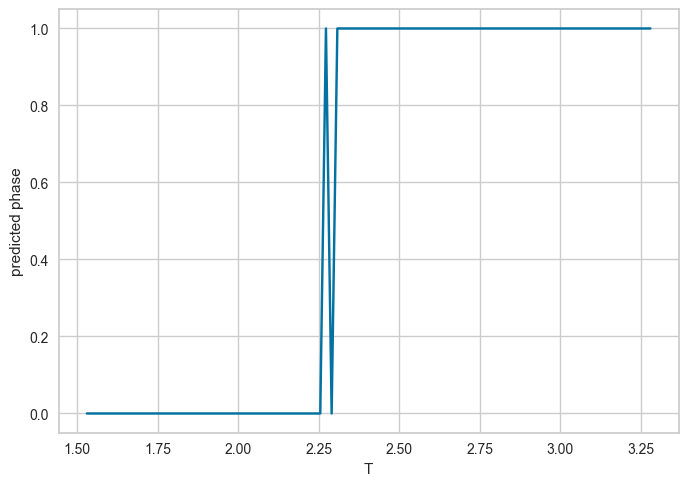

In [49]:
plt.plot(df['T'], predictions['prediction_label'])
plt.xlabel('T')
plt.ylabel('predicted phase')

In [43]:
nb = create_model('nb')

In [44]:
new_data = df.copy()
new_data.drop('T', axis=1, inplace=True)
new_data.head()

,M,phase
0,0.984032,0
1,0.983325,0
2,0.982168,0
3,0.980790,0
4,0.979728,0


In [45]:
# predict model on new_data
predictions = predict_model(nb,data = new_data)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.9900,0.9996,0.9828,1.0000,0.9913,0.9795,0.9797


,M,phase,prediction_label,prediction_score
0,0.984032,0,0,1.0
1,0.983325,0,0,1.0
2,0.982168,0,0,1.0
3,0.980790,0,0,1.0
4,0.979728,0,0,1.0


Text(0, 0.5, 'predicted phase')

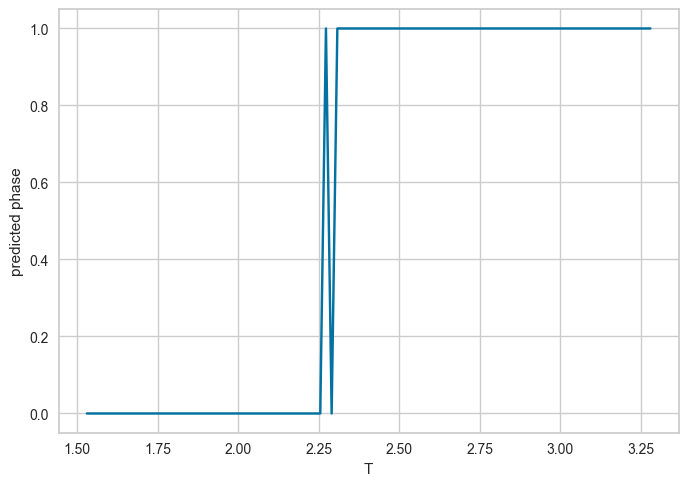

In [46]:
import matplotlib.pyplot as plt
plt.plot(df['T'], predictions['prediction_label'])
plt.xlabel('T')
plt.ylabel('predicted phase')